# Vanishing gradients debugging
Created 29/05/2024

Objectives:
* The overlap cost function is producing vanishing gradients for the fermionic SPTs and the optimisation is finishing early as a result. Need to figure out cause of vanishing gradients.

# Package imports

In [1]:
import sys

In [2]:
sys.path.append("../../")

In [3]:
from itertools import chain
import re

from collections import Counter, namedtuple

In [4]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os

In [5]:
import numpy as np
from jax import numpy as jnp

import matplotlib.pyplot as plt

import scipy

In [6]:
import quimb as qu
import quimb.tensor as qtn
from quimb.tensor.optimize import TNOptimizer

/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:54: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:36: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(
/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/cotengra/hyperoptimizers/hyper.py:73: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization.
  warnings.warn(


# Load data

In [7]:
DATA_DIR_1 = r"../../data/interpolated_trivial_to_nontrivial_fermionic_trivial_proj_rep_200_site_dmrg/"
DATA_DIR_2 = r"../../data/interpolated_nontrivial_fermionic_proj_rep_to_nontrivial_proj_rep_200_site_dmrg/"

In [8]:
def parse_file_name(file_name):
    interpolation = int(file_name.split('_')[0])/100

    return interpolation

In [9]:
loaded_data_non_triv_proj_rep = dict()
energies_non_triv_proj_rep = dict()

for local_file_name in list(os.walk(DATA_DIR_2))[0][2]:
    f_name = r"{}/{}".format(DATA_DIR_2, local_file_name, ignore_unknown=False)

    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)

        data_info = parse_file_name(local_file_name)
        loaded_data_non_triv_proj_rep[data_info]=data['wavefunction']
        energies_non_triv_proj_rep[data_info]=data['energy']

In [10]:
psi = loaded_data_non_triv_proj_rep[0]

In [11]:
Counter(
    tuple(psi.get_B(i).get_leg_labels())
    for i in range(psi.L)
)

Counter({('vL', 'p', 'vR'): 200})

In [12]:
psi_arrays = list()
psi_arrays.append(psi.get_B(0, 'Th')[0, ...].to_ndarray())
for i in range(1, psi.L-1):
    psi_arrays.append(psi.get_B(i).to_ndarray())
psi_arrays.append(psi.get_B(psi.L-1)[..., 0].to_ndarray())

In [13]:
q1 = (
    qtn
    .tensor_1d
    .MatrixProductState(
        psi_arrays,
        shape='lpr'
    )
)

# Definitions

## Define tensor network to contract against

In [14]:
np_10 = np.array([
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [1, 0, 0, 0],
    [0, 1, 0, 0]
])

In [99]:
def generate_problem_rdm(quimb_psi, symmetry_site_pairs, leftmost_symmetry_site,
                         num_symmetry_sites, num_boundary_sites):
    q_top = quimb_psi.copy(deep=True)
    for i, s in symmetry_site_pairs:
        q_top.gate(
            s,
            where=i,
            contract=False,
            inplace=True
        )

    
    indices_to_map = list(chain(
        range(leftmost_symmetry_site-num_boundary_sites, leftmost_symmetry_site),
        range(leftmost_symmetry_site+num_symmetry_sites, leftmost_symmetry_site+num_symmetry_sites+num_boundary_sites)
    ))

    index_mapping = {f'k{i}': f'b{i}' for i in indices_to_map}

    q_bottom = (
        quimb_psi
        .copy()
        .reindex(index_mapping, inplace=True)
        .conj()
    )

    sites_to_contract = {
        'left': list(range(leftmost_symmetry_site-num_boundary_sites)),
        'middle': list(range(leftmost_symmetry_site, leftmost_symmetry_site+num_symmetry_sites)),
        'right': list(range(leftmost_symmetry_site+num_symmetry_sites+num_boundary_sites, quimb_psi.L))
    }

    tags_to_contract = {
        k: [f'I{i}' for i in v]
        for k, v in sites_to_contract.items()
    }

    tn = (q_top & q_bottom)

    tnc = (
        tn
        .contract(tags_to_contract['left'])
        .contract(tags_to_contract['middle'])
        .contract(tags_to_contract['right'])
    )

    return tnc

## Initialize mpo functions

In [16]:
num_boundary_sites=6
left_most_symmetry_site=60
num_symmetry_sites=80
bond_dimension=6

In [17]:
def initialize_mpo(left_most_symmetry_site, num_symmetry_sites,
                   num_boundary_sites, bond_dimension, phys_dim=[4,2]):
    # Kind of hard coding the physical dimensions.
    ml = qtn.MPO_rand(
        num_boundary_sites,
        bond_dimension,
        phys_dim=phys_dim,
        normalize=True,
        sites=list(range(left_most_symmetry_site-num_boundary_sites, left_most_symmetry_site)),
        dtype=np.complex128,
        tags='left_mpo'
    )

    mr = qtn.MPO_rand(
        num_boundary_sites,
        bond_dimension,
        phys_dim=phys_dim,
        normalize=True,
        sites=list(range(
            left_most_symmetry_site + num_symmetry_sites,
            left_most_symmetry_site + num_symmetry_sites + num_boundary_sites
        )),
        dtype=np.complex128,
        tags='right_mpo'
    )

    mpo = (ml & mr)

    return mpo

In [72]:
def initialize_identity_mpo(left_most_symmetry_site, num_symmetry_sites,
                   num_boundary_sites, phys_dim=[4,2]):
    # Kind of hard coding the physical dimensions.
    ml = qtn.MPO_identity(
        num_boundary_sites,
        phys_dim=phys_dim,
        sites=list(range(left_most_symmetry_site-num_boundary_sites, left_most_symmetry_site)),
        dtype=np.complex128,
        tags='left_mpo'
    )

    mr = qtn.MPO_rand(
        num_boundary_sites,
        phys_dim=phys_dim,
        sites=list(range(
            left_most_symmetry_site + num_symmetry_sites,
            left_most_symmetry_site + num_symmetry_sites + num_boundary_sites
        )),
        dtype=np.complex128,
        tags='right_mpo'
    )

    mpo = (ml & mr)

    return mpo

In [79]:
def initialize_one_site_identity_mpo(left_most_symmetry_site, num_symmetry_sites,
                                     phys_dim=2):
    X = np.identity(phys_dim, dtype=np.complex128)
    left_site=left_most_symmetry_site-1

    # Kind of hard coding the physical dimensions.
    ml = qtn.Tensor(
        X,
        inds = [f'k{left_site}', f'b{left_site}'],
        tags='left_mpo'
    )

    right_site = left_most_symmetry_site + num_symmetry_sites
    mr = qtn.Tensor(
        X,
        inds = [f'k{right_site}', f'b{right_site}'],
        tags='right_mpo'
    )

    mpo = (ml & mr)

    return mpo

## Optimisation functions

In [18]:
def split_mpo_pair(mpo_pair):
    ml = qtn.TensorNetwork(
        list(map(mpo_pair.tensor_map.__getitem__, mpo.tag_map['left_mpo']))
    )

    mr = qtn.TensorNetwork(
        list(map(mpo_pair.tensor_map.__getitem__, mpo.tag_map['right_mpo']))
    )

    return (ml, mr)

In [19]:
def overlap_loss_function(ml, mr, rdm_tn, epsilon=1e-8):
    c = (rdm_tn & ml & mr) ^ ...

    c_abs_squared = (
        (c+epsilon)
        *jnp.conjugate(c+epsilon)
    )
    #c_abs_squared = c_abs_squared.astype('float32')
    c_abs = (jnp.sqrt(jnp.real(c_abs_squared)))

    loss = (c_abs - 1)**2

    return loss

In [20]:
def overlap_loss_function_mpo_pair(mpo_pair, rdm_tn):
    ml, mr = split_mpo_pair(mpo_pair)

    return overlap_loss_function(ml, mr, rdm_tn)

In [21]:
regex_s = r"^I\d+$"
regex_p = re.compile(regex_s)

In [22]:
def relabel_mpo(mpo, k_label, b_label):
    site_locs = [
        int(k[1:]) for k in mpo.tag_map
        if bool(re.search(regex_p, k))
    ]

    k_in_indices = [f'k{i}' for i in site_locs]
    j_in_indices = [f'b{i}' for i in site_locs]

    k_out_indices = [f'{k_label}{i}' for i in site_locs]
    j_out_indices = [f'{b_label}{i}' for i in site_locs]

    mapping = dict(
        chain(
            zip(k_in_indices, k_out_indices),
            zip(j_in_indices, j_out_indices)
        )
    )

    mpo.reindex(mapping, inplace=True)

In [23]:
def unitarity_tn(tn, total_physical_dim):
    ms = [tn.copy(), tn.copy(), tn.copy()]

    relabel_mpo(ms[0], 'k', 'l')
    relabel_mpo(ms[1], 'm', 'l')
    relabel_mpo(ms[2], 'm', 'b')

    ms[0] = ms[0].conj()
    ms[2] = ms[2].conj()

    n2tn = (tn & tn.conj())
    n2 = n2tn.contract(n2tn.tag_map)
    n4tn = (tn & ms[0] & ms[1] & ms[2])
    n4 = n4tn.contract(n4tn.tag_map)

    out = jnp.real(n4 - 2*n2 + total_physical_dim)

    return out

In [24]:
def overall_loss_function(mpo_pair, rdm_tn, total_physical_dimension,
    unitary_cost_coefficient=1, overlap_cost_coefficient=1, losses=None):
    ml, mr = split_mpo_pair(mpo_pair)

    o_loss = overlap_loss_function(ml, mr, rdm_tn)
    ul_loss = jnp.sqrt(1 + unitarity_tn(ml, total_physical_dimension)) - 1
    ur_loss = jnp.sqrt(1 + unitarity_tn(mr, total_physical_dimension)) - 1

    out = (
        unitary_cost_coefficient*(ul_loss+ur_loss)
        + overlap_cost_coefficient*o_loss
    )

    out = jnp.real(out)

    if losses is not None:
        losses.append((o_loss, ul_loss, ur_loss))
    return out

# Runs
## 1

In [53]:
symmetry_site_pairs = []
num_boundary_sites=1

problem_rdm = generate_problem_rdm(
    q1,
    symmetry_site_pairs,
    60,
    81,
    num_boundary_sites
)

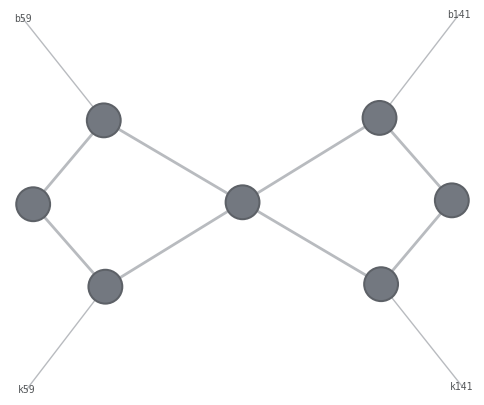

In [54]:
problem_rdm.draw()

In [55]:
problem_rdm

TensorNetwork1D(tensors=7, indices=12, L=200, max_bond=4)

In [57]:
total_physical_dim = 2

In [58]:
num_iterations = int(1e4) 
num_seeds = 10

hyperparameter_dists_dict = {
    'alpha': scipy.stats.loguniform(1e-4, 1e-2),
    'beta_1': scipy.stats.uniform(0.1, 0.5),
    'beta_2': scipy.stats.uniform(0.1, 0.5),
    'bond_dimension': scipy.stats.randint(4, 9),
    'overlap_learning_rate': scipy.stats.randint(1, 500)
}

In [59]:
HyperParams = namedtuple('HyperParams', hyperparameter_dists_dict)

In [61]:
optimizers = dict()

for _ in range(num_seeds):
    hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}

    mpo = initialize_mpo(
        60,
        81,
        1,
        hyperparams['bond_dimension'],
        2
    )

    optmzr = qtn.optimize.TNOptimizer(
        mpo,                                # our initial input, the tensors of which to optimize
        loss_fn=overall_loss_function,
        loss_kwargs={
            'rdm_tn': problem_rdm,
            'total_physical_dimension': total_physical_dim,
            'unitary_cost_coefficient': 1,
            'overlap_cost_coefficient': hyperparams['overlap_learning_rate']
        },
        autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
        optimizer='adam',               # supplied to scipy.minimize
    )

    optmzr.optimize(
        num_iterations,
        learning_rate=hyperparams['alpha'],
        beta1=hyperparams['beta_1'],
        beta2=hyperparams['beta_2']
    )

    optimizers[HyperParams(**hyperparams)] = optmzr

  0%|                                                                                                                                                                             | 0/10000 [00:00<?, ?it/s]/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from complex64 to complex128.
  warnings.warn(
+237.000015258789 [best: +237.000015258789] :  30%|█████████████████████████████████▉                                                                                | 2982/10000 [00:02<00:04, 1673.13it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, s

In [62]:
optimizer_list = [
    (k, v) for k, v in optimizers.items()
]

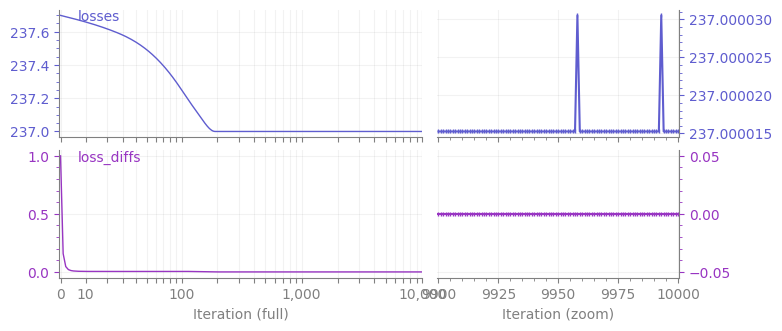

(<Figure size 800x348.22 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Iteration (full)'>,
         <Axes: xlabel='Iteration (zoom)'>]], dtype=object))

In [63]:
optimizer_list[0][1].plot()

In [64]:
optimizer_list[0][0]

HyperParams(alpha=0.0022943557542547026, beta_1=0.1676488607647019, beta_2=0.3705412273640394, bond_dimension=8, overlap_learning_rate=237)

In [65]:
mpo_opt = optimizer_list[0][1].get_tn_opt()
ml, mr = split_mpo_pair(mpo_opt)

In [66]:
(
    overlap_loss_function(ml, mr, problem_rdm),
    unitarity_tn(ml, total_physical_dim),
    unitarity_tn(mr, total_physical_dim),
)

(Array(1., dtype=float32),
 Array(2.2888184e-05, dtype=float32, weak_type=True),
 Array(2.0980835e-05, dtype=float32, weak_type=True))

Calculate for each:

In [67]:
final_scores = list()

for h, o in optimizer_list:
    mpo_opt = o.get_tn_opt()
    ml, mr = split_mpo_pair(mpo_opt)

    out = (
        overlap_loss_function(ml, mr, problem_rdm),
        unitarity_tn(ml, total_physical_dim),
        unitarity_tn(mr, total_physical_dim),
    )

    final_scores.append(out)

In [68]:
final_scores

[(Array(1., dtype=float32),
  Array(2.2888184e-05, dtype=float32, weak_type=True),
  Array(2.0980835e-05, dtype=float32, weak_type=True)),
 (Array(1., dtype=float32),
  Array(0., dtype=float32, weak_type=True),
  Array(2.3841858e-07, dtype=float32, weak_type=True)),
 (Array(1., dtype=float32),
  Array(0., dtype=float32, weak_type=True),
  Array(2.3841858e-07, dtype=float32, weak_type=True)),
 (Array(1., dtype=float32),
  Array(5.722046e-06, dtype=float32, weak_type=True),
  Array(1.9073486e-06, dtype=float32, weak_type=True)),
 (Array(1., dtype=float32),
  Array(2.3841858e-06, dtype=float32, weak_type=True),
  Array(1.9073486e-06, dtype=float32, weak_type=True)),
 (Array(1., dtype=float32),
  Array(9.536743e-07, dtype=float32, weak_type=True),
  Array(1.1920929e-06, dtype=float32, weak_type=True)),
 (Array(1., dtype=float32),
  Array(1.9073486e-06, dtype=float32, weak_type=True),
  Array(4.053116e-06, dtype=float32, weak_type=True)),
 (Array(1., dtype=float32),
  Array(4.7683716e-07, d

In [69]:
[x[0] for x in final_scores]

[Array(1., dtype=float32),
 Array(1., dtype=float32),
 Array(1., dtype=float32),
 Array(1., dtype=float32),
 Array(1., dtype=float32),
 Array(1., dtype=float32),
 Array(1., dtype=float32),
 Array(1., dtype=float32),
 Array(1., dtype=float32),
 Array(1., dtype=float32)]

## 2

In [100]:
symmetry_site_pairs = []
num_boundary_sites=1

problem_rdm = generate_problem_rdm(
    q1,
    symmetry_site_pairs,
    60,
    81,
    num_boundary_sites
)

In [101]:
num_iterations = int(1e4) 
num_seeds = 10

hyperparameter_dists_dict = {
    'alpha': scipy.stats.loguniform(1e-4, 1e-2),
    'beta_1': scipy.stats.uniform(0.1, 0.5),
    'beta_2': scipy.stats.uniform(0.1, 0.5),
    'bond_dimension': scipy.stats.randint(4, 9),
    'overlap_learning_rate': scipy.stats.randint(1, 500)
}

In [102]:
HyperParams = namedtuple('HyperParams', hyperparameter_dists_dict)

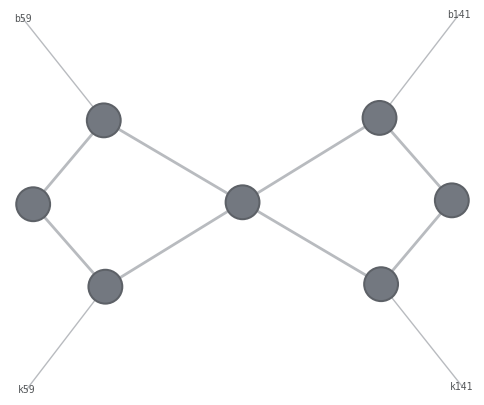

In [103]:
problem_rdm.draw()

In [104]:
mpo = initialize_one_site_identity_mpo(
    60,
    81,
    2
)

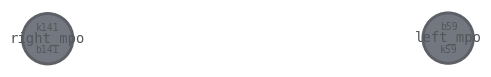

In [105]:
mpo.draw()

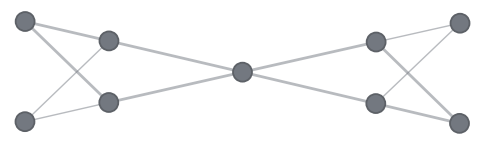

In [106]:
(problem_rdm & mpo).draw()

In [107]:
(problem_rdm & mpo) ^ ...

(0.9999999999999902+1.5289742701892655e-18j)

In [108]:
help(overlap_loss_function)

Help on function overlap_loss_function in module __main__:

overlap_loss_function(ml, mr, rdm_tn, epsilon=1e-08)



In [109]:
help(overlap_loss_function_mpo_pair)

Help on function overlap_loss_function_mpo_pair in module __main__:

overlap_loss_function_mpo_pair(mpo_pair, rdm_tn)



In [110]:
optimizers = dict()

for _ in range(num_seeds):
    hyperparams ={k: v.rvs() for k, v in hyperparameter_dists_dict.items()}

    mpo = initialize_one_site_identity_mpo(
        60,
        81,
        2
    )

    optmzr = qtn.optimize.TNOptimizer(
        mpo,                                # our initial input, the tensors of which to optimize
        loss_fn=overlap_loss_function_mpo_pair,
        loss_kwargs={
            'rdm_tn': problem_rdm,
            #'total_physical_dimension': total_physical_dim,
            #'unitary_cost_coefficient': 0,
            #'overlap_cost_coefficient': 1
        },
        autodiff_backend='jax',      # {'jax', 'tensorflow', 'autograd'}
        optimizer='adam',               # supplied to scipy.minimize
    )

    optmzr.optimize(
        num_iterations,
        learning_rate=hyperparams['alpha'],
        beta1=hyperparams['beta_1'],
        beta2=hyperparams['beta_2']
    )

    optimizers[HyperParams(**hyperparams)] = optmzr

  0%|                                                                                                                                                                             | 0/10000 [00:00<?, ?it/s]/Users/kierancooney/.pyenv/versions/num_spt_venv_p11/lib/python3.11/site-packages/quimb/tensor/optimize.py:135: UserWarning: dtype mismatch between input parameter and updated values. This can occur e.g. with jax and double precision arrays (in which case consider setting `jax.config.update("jax_enable_x64", True)` at startup or using single precision parameters directly). For now casting from complex64 to complex128.
  warnings.warn(
+0.000000000000 [best: +0.000000000000] :   0%|                                                                                                                           | 1/10000 [00:00<23:21,  7.14it/s]


# Conclusion
Was missing a conjugate!